# 简介


&ensp;&ensp;&ensp;&ensp;采用特征处理和 含有分类结果的用户数据，进行深度学习，预测用户的推送offer完成率，从而可以针对性的推送offer
- 首先对数据进行scale预处理，并分割训练集 测试集
- 通过线性回归初步预测 
- 通过多种算法预测 找到最优算法
- 对最优算法进行调参
    
    

&ensp;&ensp;Based on user data with feature processing and classification, use deep learning to predict the completion rate of push offers for all users, so that offers can be pushed specifically and effectively
- First perform scale preprocessing on the data, and split the training set and test set
- Preliminary predicte through linear regression
- Find the optimal algorithm through predictions of multiple algorithms
- Tuning the optimal algorithm

In [12]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

from matplotlib import pyplot
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

import warnings
warnings.filterwarnings('ignore')


In [13]:
def pklsave(model, filename):
    """
    This function is to save the sklearn object
    INPUT :
        model : sklearn object
        filename : filepath to saved
    RETURN : none
    """
    pickle.dump(model, open(filename,'wb'))
    
def pklload(filename):
    """
    This function is to load the saved sklearn object
    INPUT : filename : filepath
    RETURN : loaded sklearn object
    """
    return pickle.load(open(filename, 'rb'))

# 准备数据

## 加载分类数据

In [14]:
# %% 加载用户分类数据 ,分类做成字符类别
profile_cluster = pd.read_csv('data/profile_cluster.csv')
# 用户id 作为 index
profile_cluster = profile_cluster.set_index(profile_cluster.columns[0])

# rename cluster name to m_1, m_2, etc
profile_cluster['cluster'] = profile_cluster['cluster'].apply(lambda x: 'm_'+ str(x))

# check for null data
print( profile_cluster.isnull().sum().sum() ) 

0


## 选取特征

In [15]:
#%% 把特征分为 X 和 Y ， Y 包括两个rate 为预测值, X包括用户属性 和cluster
features = ['age',
 'income',
 'avg_spending',
 'gender_F',
 'gender_M',
 'gender_O',
 'invalid_count',
 'member_days_since',
 'member_year_2013',
 'member_year_2014',
 'member_year_2015',
 'member_year_2016',
 'member_year_2017',
 'member_year_2018',
 'sum_spending',
 'transaction_count', 
 'cluster']

X = profile_cluster[features]
target_cols = ['rate_comp_rec', 'rate_comp_view']
y = profile_cluster[target_cols]

## onehot

In [16]:
# cluster列 做成 onehot

X_one_hot = pd.get_dummies(X)

def one_hot(df):
    return pd.get_dummies(df)
X_one_hot.columns


Index(['age', 'income', 'avg_spending', 'gender_F', 'gender_M', 'gender_O',
       'invalid_count', 'member_days_since', 'member_year_2013',
       'member_year_2014', 'member_year_2015', 'member_year_2016',
       'member_year_2017', 'member_year_2018', 'sum_spending',
       'transaction_count', 'cluster_m_0', 'cluster_m_1', 'cluster_m_10',
       'cluster_m_11', 'cluster_m_2', 'cluster_m_3', 'cluster_m_4',
       'cluster_m_5', 'cluster_m_6', 'cluster_m_7', 'cluster_m_8',
       'cluster_m_9'],
      dtype='object')

## Scale

In [17]:
##  Feature Scaling

from sklearn.preprocessing import StandardScaler, RobustScaler

def scaling(features):
    scale = StandardScaler()
    scale.fit(features)
    features_std = pd.DataFrame(scale.transform(features), index= features.index, columns=features.columns)
    return features_std

X_std = scaling(X_one_hot)


## Split

In [18]:

def get_train_test(features, target):
    
    """ Split : Train - Test """
    from sklearn.model_selection import train_test_split as tts
    X_train, X_test, y_train, y_test = tts(features, target, test_size=0.33, random_state=42)   
    return X_train, X_test, y_train, y_test

# as feature scaling will be included in model pipeline
# the data will be split after performing one hot encoding.

X_train, X_test, y_train, y_test = get_train_test(X_one_hot, y)

# 机器学习 

In [19]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import  mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression


## LinearRegression

In [20]:
# 设定随机种子43 用 LinearRegression 预测，r2_arr和 mean_squared_error来评价
from sklearn.linear_model import LinearRegression


seed=42
np.random.seed(seed)
estimators = [('standardize', StandardScaler()),
             ('reg', MultiOutputRegressor(LinearRegression()))]

pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed) # ？？？？？？？？？？？？？？？？
results = cross_validate(pipeline, X_train, y_train, cv=kfold, scoring=['r2','neg_mean_squared_error'])

r2_arr = results['test_r2']
mse_arr = results['test_neg_mean_squared_error']*-1

print(f"R^2: {r2_arr.mean():.4f} with stdev {r2_arr.std():.4f}")
print(f"MSE: {mse_arr.mean():.4f} with stdev {mse_arr.std():.4f}")

R^2: 0.4084 with stdev 0.0267
MSE: 0.0633 with stdev 0.0033


##  Finding  alogrithm. 

In [21]:

# create a dict of standard models to evaluate {name:object} for MultiOutputRegressor
def get_models_multioutput(models=dict()):
    # linear models
    models['lr'] = MultiOutputRegressor(LinearRegression())
    alpha = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for a in alpha:
        models['lasso-'+str(a)] = MultiOutputRegressor(Lasso(alpha=a))
    for a in alpha:
        models['ridge-'+str(a)] = MultiOutputRegressor(Ridge(alpha=a))
    for a1 in alpha:
        for a2 in alpha:
            name = 'en-' + str(a1) + '-' + str(a2)
            models[name] = MultiOutputRegressor(ElasticNet(a1, a2))
    models['huber'] = MultiOutputRegressor(HuberRegressor())
    models['lars'] = MultiOutputRegressor(Lars())
    models['llars'] = MultiOutputRegressor(LassoLars())
    models['pa'] = MultiOutputRegressor(PassiveAggressiveRegressor(max_iter=1000, tol=1e-3))
    models['ranscac'] = MultiOutputRegressor(RANSACRegressor())
    models['sgd'] = MultiOutputRegressor(SGDRegressor(max_iter=1000, tol=1e-3))
    models['theil'] = MultiOutputRegressor(TheilSenRegressor())
    # non-linear models
    n_neighbors = range(1, 21)
    for k in n_neighbors:
        models['knn-'+str(k)] = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=k))
    models['cart'] = MultiOutputRegressor(DecisionTreeRegressor())
    models['extra'] = MultiOutputRegressor(ExtraTreeRegressor())
    models['svml'] = MultiOutputRegressor(SVR(kernel='linear'))
    models['svmp'] = MultiOutputRegressor(SVR(kernel='poly'))
    c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for c in c_values:
        models['svmr'+str(c)] = SVR(C=c)
    # ensemble models
    n_trees = 100
    models['ada'] = MultiOutputRegressor(AdaBoostRegressor(n_estimators=n_trees))
    models['bag'] = MultiOutputRegressor(BaggingRegressor(n_estimators=n_trees))
    models['rf'] = MultiOutputRegressor(RandomForestRegressor(n_estimators=n_trees))
    models['et'] = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=n_trees))
    models['gbm'] = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=n_trees))
    print('Defined %d models' % len(models))
    return models

# create a feature preparation pipeline for a model
def make_pipeline(model):
    steps = list()
    # standardization
    steps.append(('standardize', StandardScaler()))
    # normalization
    steps.append(('normalize', MinMaxScaler()))
    # the model
    steps.append(('model', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline

# evaluate a single model
def evaluate_model(X, y, model, folds, metric):
    # create the pipeline
    pipeline = make_pipeline(model)
    # evaluate model
    scores = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
    return scores

# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, metric):
    scores = None
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            scores = evaluate_model(X, y, model, folds, metric)
    except:
        scores = None
    return scores

# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=10, metric='accuracy'):
    results = dict()
    for name, model in models.items():
        # evaluate the model
        scores = robust_evaluate_model(X, y, model, folds, metric)
        # show process
        if scores is not None:
            # store a result
            results[name] = scores
            mean_score, std_score = np.mean(scores), np.std(scores)
            print('>%s: %.3f (+/-%.3f)' % (name, mean_score, std_score))
        else:
            print('>%s: error' % name)
    return results


In [22]:
# get model list
models = get_models_multioutput()   
# evaluate models
results = evaluate_models(X_train, y_train, models, metric='neg_mean_squared_error')


Defined 190 models
>lr: -1013531858180976017408.000 (+/-2387938681014755786752.000)
>lasso-0.0: -0.063 (+/-0.003)
>lasso-0.1: -0.107 (+/-0.003)
>lasso-0.2: -0.107 (+/-0.003)
>lasso-0.3: -0.107 (+/-0.003)
>lasso-0.4: -0.107 (+/-0.003)
>lasso-0.5: -0.107 (+/-0.003)
>lasso-0.6: -0.107 (+/-0.003)
>lasso-0.7: -0.107 (+/-0.003)
>lasso-0.8: -0.107 (+/-0.003)
>lasso-0.9: -0.107 (+/-0.003)
>lasso-1.0: -0.107 (+/-0.003)
>ridge-0.0: -111737172849561398411264.000 (+/-314809984480779272454144.000)
>ridge-0.1: -0.063 (+/-0.003)
>ridge-0.2: -0.063 (+/-0.003)
>ridge-0.3: -0.063 (+/-0.003)
>ridge-0.4: -0.063 (+/-0.003)
>ridge-0.5: -0.063 (+/-0.003)
>ridge-0.6: -0.063 (+/-0.003)
>ridge-0.7: -0.063 (+/-0.003)
>ridge-0.8: -0.063 (+/-0.003)
>ridge-0.9: -0.063 (+/-0.003)
>ridge-1.0: -0.063 (+/-0.003)
>en-0.0-0.0: -0.063 (+/-0.003)
>en-0.0-0.1: -0.063 (+/-0.003)
>en-0.0-0.2: -0.063 (+/-0.003)
>en-0.0-0.3: -0.063 (+/-0.003)
>en-0.0-0.4: -0.063 (+/-0.003)
>en-0.0-0.5: -0.063 (+/-0.003)
>en-0.0-0.6: -0.063 (+/-

In [23]:
def summarize_results(results, maximize=True, top_n=10):
    # check for no results
    if len(results) == 0:
        print('no results')
        return
    # determine how many results to summarize
    n = min(top_n, len(results))
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k,np.mean(v)) for k,v in results.items()]
    
    mean_scores_nonan = []
    for k in range(len(mean_scores)) :
        if  math.isnan( mean_scores[k][1] )!= True :
            mean_scores_nonan.append(mean_scores[k])      
    
    # sort tuples by mean score
    mean_scores_nonan = sorted(mean_scores_nonan, key=lambda x: x[1])
    # reverse for descending order (e.g. for accuracy)
    if maximize:
        mean_scores_nonan = list(reversed(mean_scores_nonan))
    # retrieve the top n for summarization
    names = [x[0] for x in mean_scores_nonan[:n]]
    scores = [results[x[0]] for x in mean_scores_nonan[:n]]
    # print the top n
    print()
    for i in range(n):
        name = names[i]
        mean_score, std_score = np.mean(results[name]), np.std(results[name])
        print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
    # boxplot for the top n
    pyplot.boxplot(scores, labels=names)
    _, labels = pyplot.xticks()
    pyplot.setp(labels, rotation=90)
    #pyplot.savefig('spotcheck.png')


Rank=1, Name=gbm, Score=-0.055 (+/- 0.003)
Rank=2, Name=bag, Score=-0.059 (+/- 0.004)
Rank=3, Name=rf, Score=-0.059 (+/- 0.004)
Rank=4, Name=svmp, Score=-0.059 (+/- 0.003)
Rank=5, Name=et, Score=-0.062 (+/- 0.003)
Rank=6, Name=knn-20, Score=-0.062 (+/- 0.003)
Rank=7, Name=knn-19, Score=-0.062 (+/- 0.003)
Rank=8, Name=knn-18, Score=-0.062 (+/- 0.003)
Rank=9, Name=knn-17, Score=-0.062 (+/- 0.003)
Rank=10, Name=knn-16, Score=-0.063 (+/- 0.003)


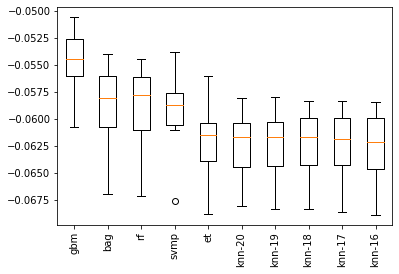

In [24]:
summarize_results(results)


##  Selected Model - Gradient boosting

In [25]:
# The Selected Model - Gradient boosting

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

seed=42
np.random.seed(seed)
estimators = [('standardize', StandardScaler()),
             ('reg', MultiOutputRegressor(GradientBoostingRegressor(random_state=seed)))]

pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_validate(pipeline, X_train, y_train, cv=kfold, scoring=['r2','neg_mean_squared_error'])

r2_arr = results['test_r2']
mse_arr = results['test_neg_mean_squared_error']*-1

print(f"R^2: {r2_arr.mean():.4f} with stdev {r2_arr.std():.4f}")
print(f"MSE: {mse_arr.mean():.4f} with stdev {mse_arr.std():.4f}")


R^2: 0.4925 with stdev 0.0221
MSE: 0.0546 with stdev 0.0029


## 调参数


In [26]:
""" Model Tuning """
# Import 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# Initialize the classifier
seed=42
np.random.seed(seed)
reg = MultiOutputRegressor(GradientBoostingRegressor(random_state=seed))
print(reg)

MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9,
                                                         ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='ls', max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_

In [27]:
parameters = {'estimator__n_estimators':[50, 75,100,200,300, 500], 
              'estimator__max_depth' : [2,3,5,8,10, None],
              'estimator__min_samples_split' : [2,5,7,9,12],
              'estimator__min_samples_leaf' : [1,3,5,7,9]
             }

# Perform grid search 
grid_obj = RandomizedSearchCV(reg, param_distributions=parameters,n_iter = 50,scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)
# Fit the grid search object to the training data 
grid_fit = grid_obj.fit(X_train, y_train)
# Get the estimator
best_reg = grid_fit.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 10

In [28]:

print('Tuned Model')
print('R^2 score : ', best_reg.score(X_test, y_test))
print('MSE : ', mean_squared_error(y_test, best_reg.predict(X_test)))


Tuned Model
R^2 score :  0.4899010925056648
MSE :  0.05459027872088544


In [29]:
print( best_reg ) 

#  保存最佳网格参数
pklsave(best_reg, 'sav/best_reg.sav')


MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9,
                                                         ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='ls', max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=5,
                                                         min_samples_split=2,
                                                         min_weight_fraction_

# 小结

- 采用线性回归方法 得分 R^2:0.4084 MSE:0.0633
- 采用Gradient boosting方法 得分 R^2: 0.4925 MSE: 0.0546 
- 采用调参后的Gradient boosting方法 得分 R^2 score:0.4899  MSE:0.0546
- 最终模型准确率并不高，可能是因为特征提取的还不够 需要更多特征 比如提取用户 对每一种推送offer接收数量、完成数量和完成/接收率，以及提取用户的年龄分组
    
    
- Using linear regression method， Score R^2: 0.4084  MSE: 0.0633
- Using Gradient boosting method， Score R^2: 0.4925  MSE: 0.0546
- Tuning the Gradient boosting method, Score R^2: 0.4899  MSE: 0.0546
- The accuracy of the final model is not high. It may be that the feature extraction is not enough. More features are needed, such as extracting users' received count, completed count, and completed/received rates for each type of pushed offer , as well as users' age group.